In [1]:
import os
import sys
from glob import glob

import pandas as pd
import numpy as np
from tqdm import tqdm

import omnialigner as om

plt = om.pl.plt

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [38]:
om_data = om.omni_3D.Omni3D(config_info="../config/CRC/config_CRC1.yaml")
overwrite_cache = False

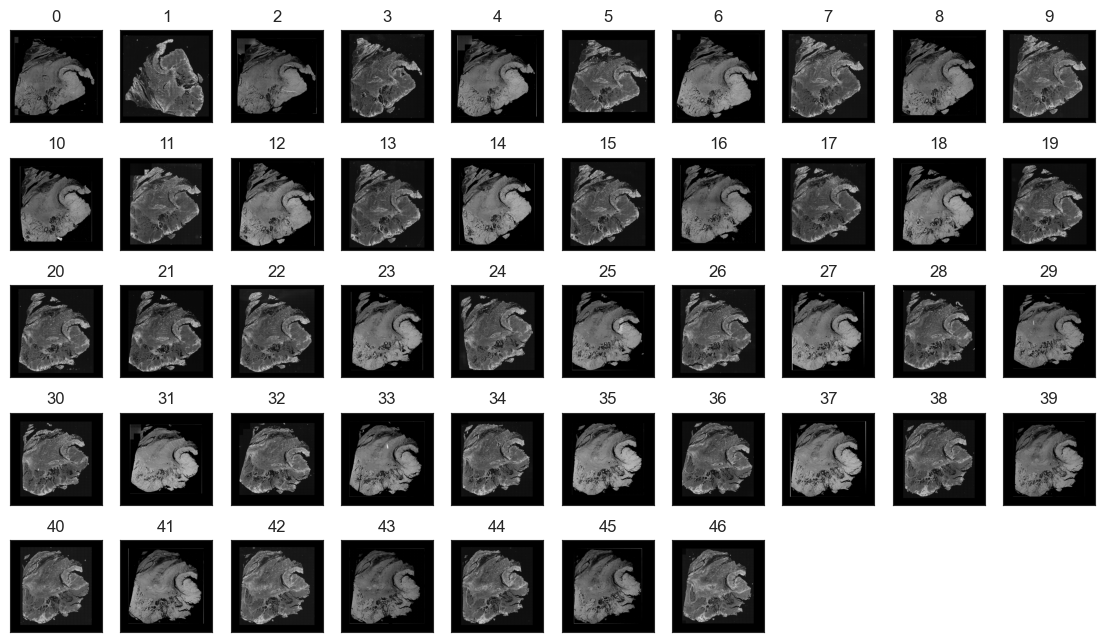

In [3]:
padded_tensor = om.pp.pad(om_data, overwrite_cache=overwrite_cache)
om.pl.plot_nchw_2d(om_data, aligned_tag="PAD")


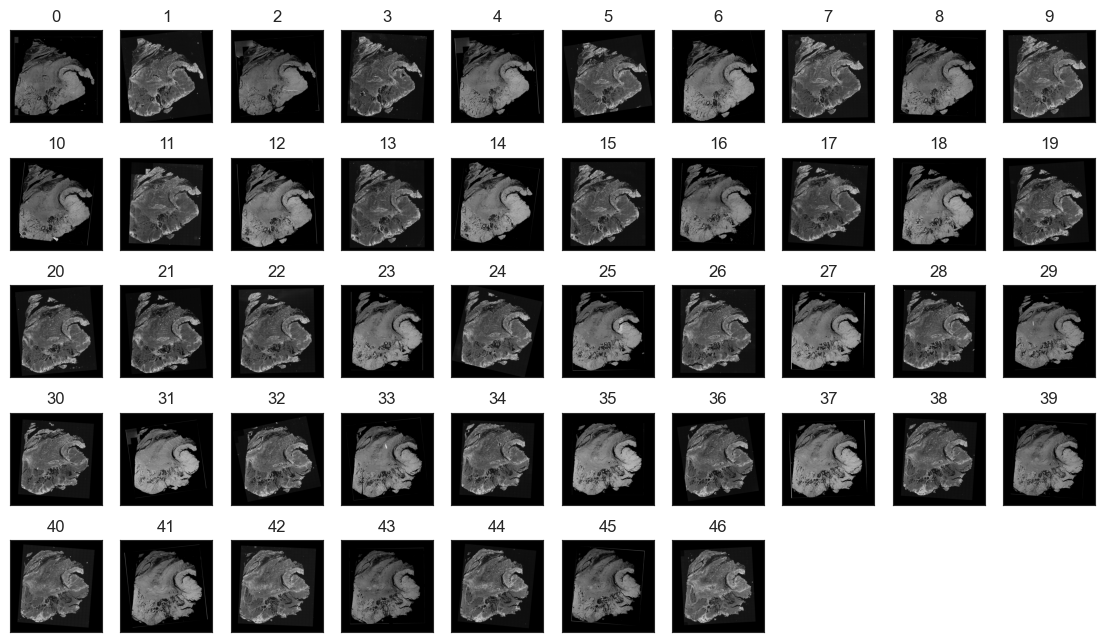

In [4]:
padded_tensor = om.align.stack(om_data, overwrite_cache=overwrite_cache)
om.pl.plot_nchw_2d(om_data, aligned_tag="STACK")


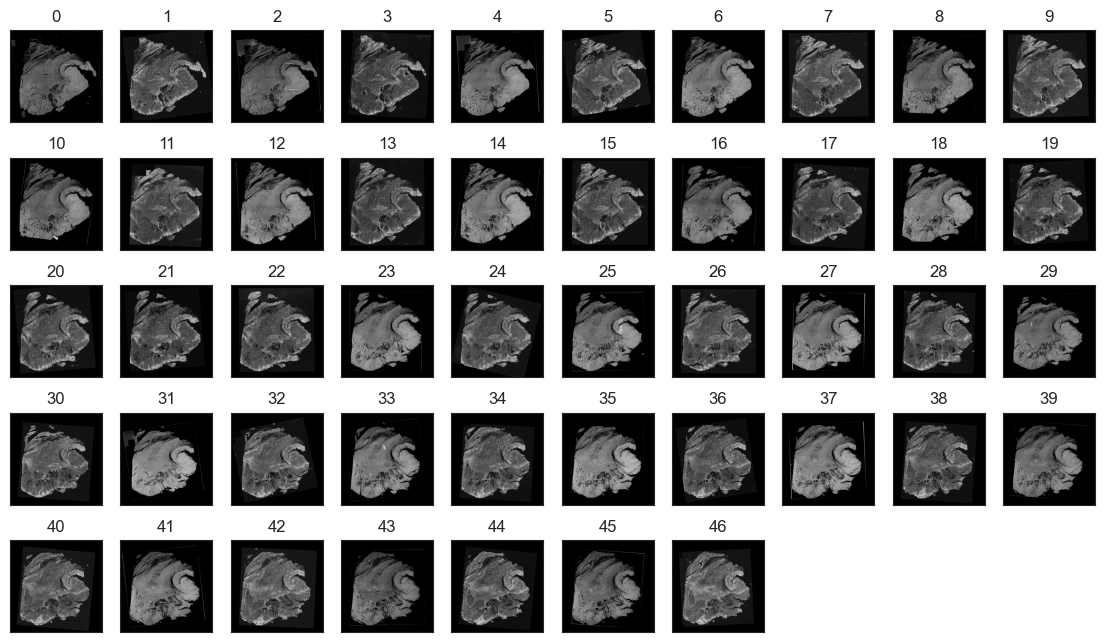

In [5]:
padded_tensor = om.align.affine(om_data, overwrite_cache=overwrite_cache)
om.pl.plot_nchw_2d(om_data, aligned_tag="AFFINE")


In [2]:
om_data = om.omni_3D.Omni3D(config_info="../config/CRC/config_CRC1.yaml")
padded_tensor = om.align.nonrigid(om_data, overwrite_cache=True)
om.pl.plot_nchw_2d(om_data, aligned_tag="NONRIGID")


create_pyramid 7
create_pyramid 6
create_pyramid 5
create_pyramid 4
create_pyramid 3
create_pyramid 2
create_pyramid 1
create_pyramid 0
self.config_model {'model': 'omnialigner.align.models.grid_2d.DeeperHistRegModule', 'n_keypoints': 1000, 'optimizer': {'optimizer_name': 'torch.optim.Adam', 'lr': 0.0005}, 'scheduler': {'scheduler_name': 'torch.optim.lr_scheduler.CosineAnnealingWarmRestarts', 'T_0': 70, 'T_mult': 2}, 'tensor_resize': [600, 600], 'weight_image': 10, 'weight_reg': 100, 'weight_kpts': 1000.0, 'freezed_layers': [0, 10, 20, 30, 40], 'grid_size': 16, 'show_ovlp': True, 'cost_function': {'ncc_local': {'weight': 1.0, 'params': {'win_size': 7}}}, 'registration_size': 8192, 'regularization_function': {'omnialigner.metrics.diffusion_relative': {'weight': 1.0, 'params': {}}, 'omnialigner.metrics.l1_mean': {'weight': 1, 'params': {'p': 1}}}, 'num_levels': 8, 'used_levels': 5, 'learning_rates': [0.0005, 0.0004, 0.0003, 0.0002, 0.0001, 5e-05], 'iterations': [200, 200, 200, 200, 200, 

epoch 0 iter: 100%|██████████| 200/200 [04:27<00:00,  1.34s/it]


layer 0-31, Epoch 1/5, Loss: 28.7224


epoch 0 iter: 100%|██████████| 200/200 [02:35<00:00,  1.29it/s]


layer 24-46, Epoch 1/5, Loss: 33.2598


epoch 1 iter: 100%|██████████| 200/200 [04:07<00:00,  1.24s/it]


layer 0-31, Epoch 2/5, Loss: 42.0804


epoch 1 iter: 100%|██████████| 200/200 [02:33<00:00,  1.30it/s]


layer 24-46, Epoch 2/5, Loss: 43.3408


epoch 2 iter:  48%|████▊     | 97/200 [01:57<02:04,  1.21s/it]


KeyboardInterrupt: 

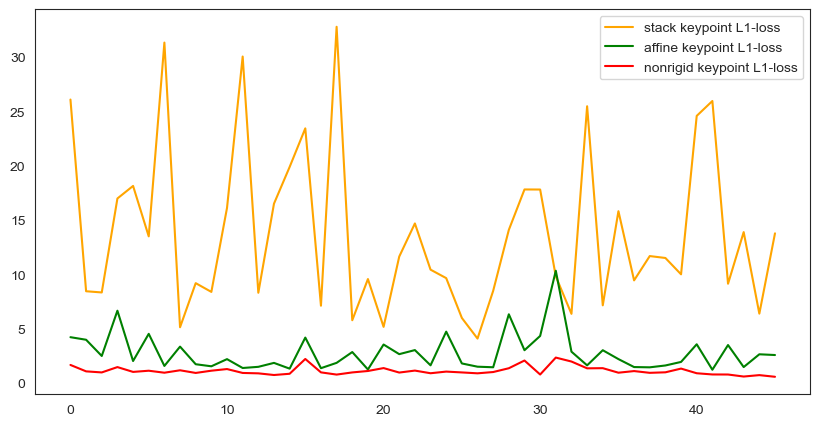

In [91]:
import torch
from omnialigner.metrics import rtre, ncc_local
from omnialigner.cache_files import StageTag

func_loss = lambda pair : torch.mean(torch.abs((pair[0] - pair[1])))
dict_file_name = StageTag.STACK.get_file_name(om_data.proj_info)
l_kpts = torch.load(dict_file_name["l_kpts_pairs"])
loss_kpts_stack = []
for idx_F in range(len(l_kpts)):    
    loss_kpts_stack.append(func_loss(l_kpts[idx_F]))

func_loss = lambda pair : torch.mean(torch.abs((pair[0]*om_data.max_size - pair[1]*om_data.max_size)))
dict_file_name = StageTag.AFFINE.get_file_name(om_data.proj_info)
l_kpts_affine = torch.load(dict_file_name["affine_kpts"])
loss_kpts_affine = []
for idx_F in range(len(l_kpts_affine)):    
    loss_kpts_affine.append(func_loss(l_kpts_affine[idx_F][0]))


dict_file_name = StageTag.NONRIGID.get_file_name(om_data.proj_info)
l_kpts_nonrigid = torch.load(dict_file_name["nonrigid_kpts"])
loss_kpts_nonrigid = []
for idx_F in range(len(l_kpts_nonrigid)):
    n_affine = len(l_kpts_affine[idx_F][0][0])
    pair = [l_kpts_nonrigid[idx_F][0][0][0:n_affine], l_kpts_nonrigid[idx_F][0][1][0:n_affine]]
    # loss_kpts_nonrigid.append(func_loss(pair))
    loss_kpts_nonrigid.append(func_loss(l_kpts_nonrigid[idx_F][0]))
    
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(loss_kpts_stack, c="orange", label='stack keypoint L1-loss')
ax1.plot(loss_kpts_affine, c="green", label='affine keypoint L1-loss')
ax1.plot(loss_kpts_nonrigid, c="red", label='nonrigid keypoint L1-loss')
ax1.legend()
# fig.savefig("figs4A.pdf")


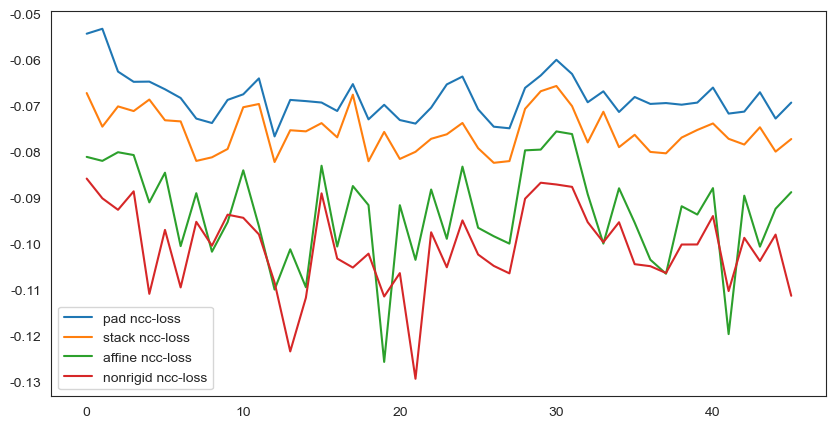

In [92]:
from omnialigner.metrics import ncc_local

dict_file_name = StageTag.NONRIGID.get_file_name(om_data.proj_info, check_exist=False)

dict_loss_img = {}
for stage in [StageTag.PAD, StageTag.STACK, StageTag.AFFINE, StageTag.NONRIGID]: 
    dict_file_name = stage.get_file_name(om_data.proj_info)
    padded_tensor = torch.load(dict_file_name["padded_tensor"])
    loss_img = []
    for idx_F in range(len(padded_tensor)-1):    
        loss_img.append(ncc_local(padded_tensor[idx_F:idx_F+1], padded_tensor[idx_F+1:idx_F+2]))
    dict_loss_img[stage] = loss_img

    
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(dict_loss_img[StageTag.PAD], label='pad ncc-loss')
ax1.plot(dict_loss_img[StageTag.STACK], label='stack ncc-loss')
ax1.plot(dict_loss_img[StageTag.AFFINE], label='affine ncc-loss')
ax1.plot(dict_loss_img[StageTag.NONRIGID], label='nonrigid ncc-loss')
ax1.legend()
# fig.savefig("figs4B.pdf")

In [24]:
from omnialigner.cache_files import DataType
om_data.set_tag(DataType.RAW)
da_raw_hd = om_data.load_tiff(1, zoom_level=0)
da_raw_hd

dask.array<affine_transform, shape=(56316, 59754, 40), dtype=uint8, chunksize=(28158, 29877, 40), chunktype=numpy.ndarray>

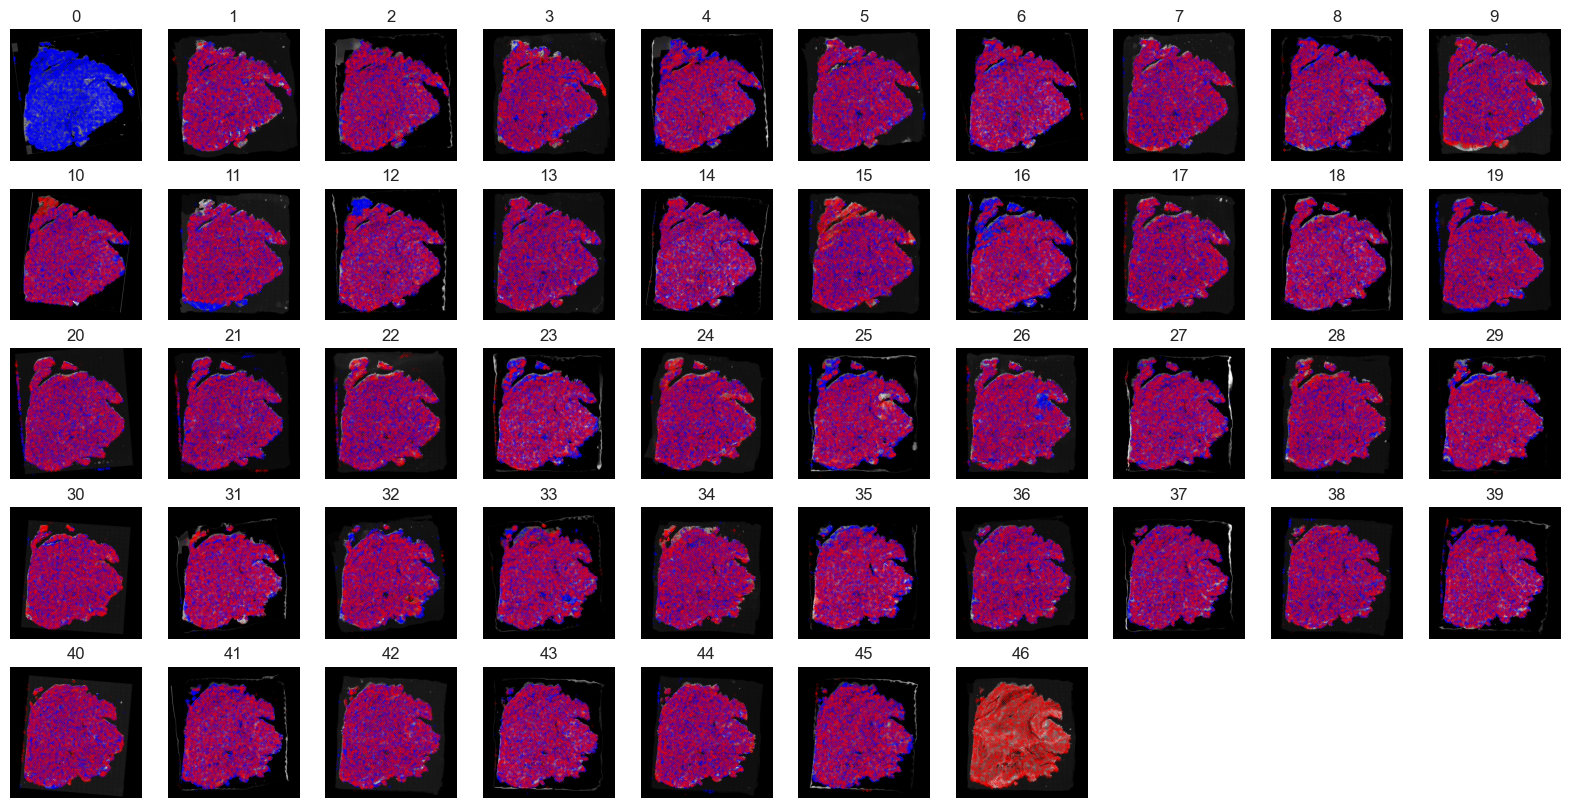

In [19]:

padded_tensor = om_data.load_3d_NCHW("NONRIGID")
fig = plt.figure(figsize=(20, 10))
for i_layer in range(len(om_data)):
    ax = fig.add_subplot(5, 10, i_layer+1)
    ax.imshow(om.tl.tensor2im(padded_tensor[i_layer:i_layer+1, :, :, :]), cmap="gray")

    
    if i_layer < len(om_data)-1:
        n_affine = len(l_kpts_affine[i_layer][0][0])
        kpt_pairs = l_kpts_nonrigid[i_layer][0][0]
        ax.scatter(kpt_pairs[n_affine:, 0]*om_data.max_size, kpt_pairs[n_affine:, 1]*om_data.max_size, c="blue", s=0.1, alpha=0.5)
    
    if i_layer > 0:
        n_affine = len(l_kpts_affine[i_layer-1][0][1])
        kpt_pairs = l_kpts_nonrigid[i_layer-1][0][1]
        ax.scatter(kpt_pairs[n_affine:, 0]*om_data.max_size, kpt_pairs[n_affine:, 1]*om_data.max_size, c="red", s=0.03, alpha=0.5)

    ax.set_title(f"{i_layer}")
    ax.axis('off')
    



In [ ]:
om_data.set_zoom_level(6)


da_HD = om.align.apply_nonrigid_HD(om_data, i_layer=0, tag="SUB")
da_HD

dask.array<from-zarr, shape=(1000, 1000, 1536), dtype=float32, chunksize=(1000, 1000, 1), chunktype=numpy.ndarray>